In [4]:
import numpy as np
import pandas as pd
from GENIE3 import *
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Ranking of feature importance for genes.

In [10]:
allImp = np.load("result_data/NormalizedImp100.npy")
gene = np.load('data/geneAfterDiscard_0.npy', allow_pickle=True)

impSum = allImp.sum(axis = 0)

geneIdx = [i for i in range(gene.shape[0])]

toSort = zip(geneIdx, impSum)
sortedImp = sorted(toSort, key=lambda x: x[1], reverse=1)

sortedImp = np.array(list(zip(*sortedImp)))

sortedIdx = sortedImp[0].astype(int)
print(sortedIdx.shape)
print(sortedIdx)

(11959,)
[ 3774 10578  7189 ... 11208  6763  6609]


In [9]:
data = np.load('data/oversampled_data.npy', allow_pickle=True)

feature = data[:, :-1]
label = data[:, -1]
print(gene.shape)
print(feature.shape)
print(label.shape)

(11959,)
(296, 11959)
(296,)


# Select the satisfactory gene.

In [4]:
ISGnum = 60

ISGidx = sortedIdx[:ISGnum]

ISGfeature = feature[:, ISGidx]
ISGgene_np = gene[ISGidx]
ISGgene_list = gene[ISGidx].tolist()


# Gaussian normalization and GENIE3

In [5]:
mean = ISGfeature.mean(axis = 0)
std = ISGfeature.std(axis = 0)
ISGfeature = ISGfeature - mean
ISGfeature = ISGfeature / std


# # Genes that are used as candidate regulators
# regulators = ['CD19', 'CDH17','RAD51','OSR2','TBX3']
# VIM2 = GENIE3(data,gene_names=gene_names,regulators=regulators)

VIM = GENIE3(ISGfeature, nthreads = 8) #data,tree_method=tree_method,K=K,ntrees=ntrees, 

get_link_list(VIM, gene_names=ISGgene_list, file_name='result_data/GENIE3_ranking.txt') # regulators=regulators,

In [6]:
relation_rank = pd.read_csv("result_data/GENIE3_ranking.txt", sep = "\t", header = None)
relation_rank

,0,1,2
0,MRPS31,WBP4,0.137821
1,GTF2F2,WBP4,0.135550
2,WBP4,GTF2F2,0.126252
3,NDUFAF2,SMN1,0.123530
4,MED6,ISCA2,0.121991
...,...,...,...
3535,ABHD13,NDUFAF2,0.003047
3536,SPAG1,MED6,0.002920
3537,FIGN,MED6,0.002860
3538,SBDS,MED6,0.002845


# Calculate the regulatory importance of genes.

In [7]:
weight = [0 for i in range(ISGnum)]

for i in relation_rank.index:
    weight[np.argwhere(ISGgene_np == relation_rank.iloc[i, 0])[0][0]] += relation_rank.iloc[i, 2]
    weight[np.argwhere(ISGgene_np == relation_rank.iloc[i, 1])[0][0]] += relation_rank.iloc[i, 2]

weight = np.array(weight)
weight

array([2.046913, 1.844898, 1.963661, 2.192506, 2.102893, 1.827292,
       1.778441, 2.449107, 2.238635, 1.53107 , 1.686881, 2.303935,
       1.725211, 1.95109 , 1.68689 , 1.867994, 1.656146, 1.952795,
       2.112143, 1.959008, 2.792928, 1.6899  , 1.99148 , 1.682505,
       2.454307, 2.34989 , 2.233608, 2.019755, 1.95112 , 1.668505,
       2.248512, 1.943301, 2.243496, 2.643075, 1.746336, 1.804424,
       2.184997, 1.837602, 1.803034, 1.769934, 1.730054, 1.893024,
       2.023393, 2.814168, 1.856905, 1.554839, 1.613114, 2.086422,
       1.835335, 2.220719, 1.814535, 2.227158, 2.168752, 2.306678,
       2.623051, 1.64101 , 1.577349, 1.728222, 1.955206, 1.95077 ])

# Genes are sorted in ascending order according to regulatory importance.

In [8]:
order_idx = np.argsort(weight)

order_gene = ISGgene_np[order_idx]
np.savetxt('regulatory_importance_ranking.txt', np.c_[order_gene], fmt='%s',delimiter='\t')
order_gene

array(['SPAG1', 'FIGN', 'NUBPL', 'CHMP5', 'TCF7L2', 'COQ10B', 'BSDC1',
       'ABHD13', 'USP33', 'ZFPM1', 'USP45', 'EIF3J', 'SBDS', 'BPHL',
       'NR1H2', 'C2orf49', 'TMEM223', 'CWC22', 'ATP2C1', 'UNC50', 'CDC16',
       'ALG2', 'SMPD2', 'TRIM39', 'BDKRB1', 'PDF', 'CX3CL1', 'RDH11',
       'SMN1', 'C7orf50', 'FGFBP1', 'WBP4', 'VPS25', 'TRMT61A', 'PIGH',
       'DDX19B', 'MMP17', 'PWP1', 'GARS', 'CREBBP', 'DHRS7', 'ADK',
       'TMEM199', 'GRPEL1', 'PPT2', 'MRPS31', 'ZNF165', 'SLC35A1',
       'GTF2F2', 'ZNF563', 'DNAJC25', 'STK19', 'EIF2S1', 'EIF2B2',
       'RBM45', 'ISCA2', 'ATP6V1D', 'NOL7', 'MED6', 'NDUFAF2'],
      dtype=object)

In [9]:
feature_after_GENIE3 = ISGfeature[:, order_idx]
feature_after_GENIE3.shape

(296, 60)

# Ranked genes were tested using Random Forest.

In [10]:
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [11]:
final_gene_num = 60

In [12]:
times = final_gene_num
geneNum = np.arange(1, times + 1)

In [13]:
acc = []
prec = []
rec = []
auc = []

# train-test split    random_state=2022
X_train, X_test, y_train, y_test = train_test_split(feature_after_GENIE3, label, test_size=0.3, shuffle=True, random_state=2022)

for i in range(1, times + 1):
    # Gradually increase the number of genes.
    xTrain = X_train[:, :i]
    xTest = X_test[:, :i]

    allAcc = []
    allPrec = []
    allRec = []
    allAuc = []
    
    for _ in range(5):
        rf = RandomForestClassifier()
        rf.fit(xTrain, y_train)  
        y_pred = rf.predict(xTest)
        
        allAcc.append(accuracy_score(y_test, y_pred))
        allPrec.append(precision_score(y_test, y_pred))
        allRec.append(recall_score(y_test, y_pred))
        predict_prob_y = rf.predict_proba(xTest)[:, 1]
        allAuc.append(roc_auc_score(y_test, predict_prob_y))

        
    acc.append(np.array(allAcc).mean())
    prec.append(np.array(allPrec).mean())
    rec.append(np.array(allRec).mean())
    auc.append(np.array(allAuc).mean())

In [14]:
geneNum = np.array(geneNum)
acc = np.array(acc)
prec = np.array(prec)
rec = np.array(rec)
auc = np.array(auc)

path = "result_data/"
np.save(path + "genie3_asc_acc.npy", acc)
np.save(path + "genie3_asc_prec.npy", prec)
np.save(path + "genie3_asc_rec.npy", rec)
np.save(path + "genie3_asc_auc.npy", auc)

In [17]:
ISGnum = bar = 60

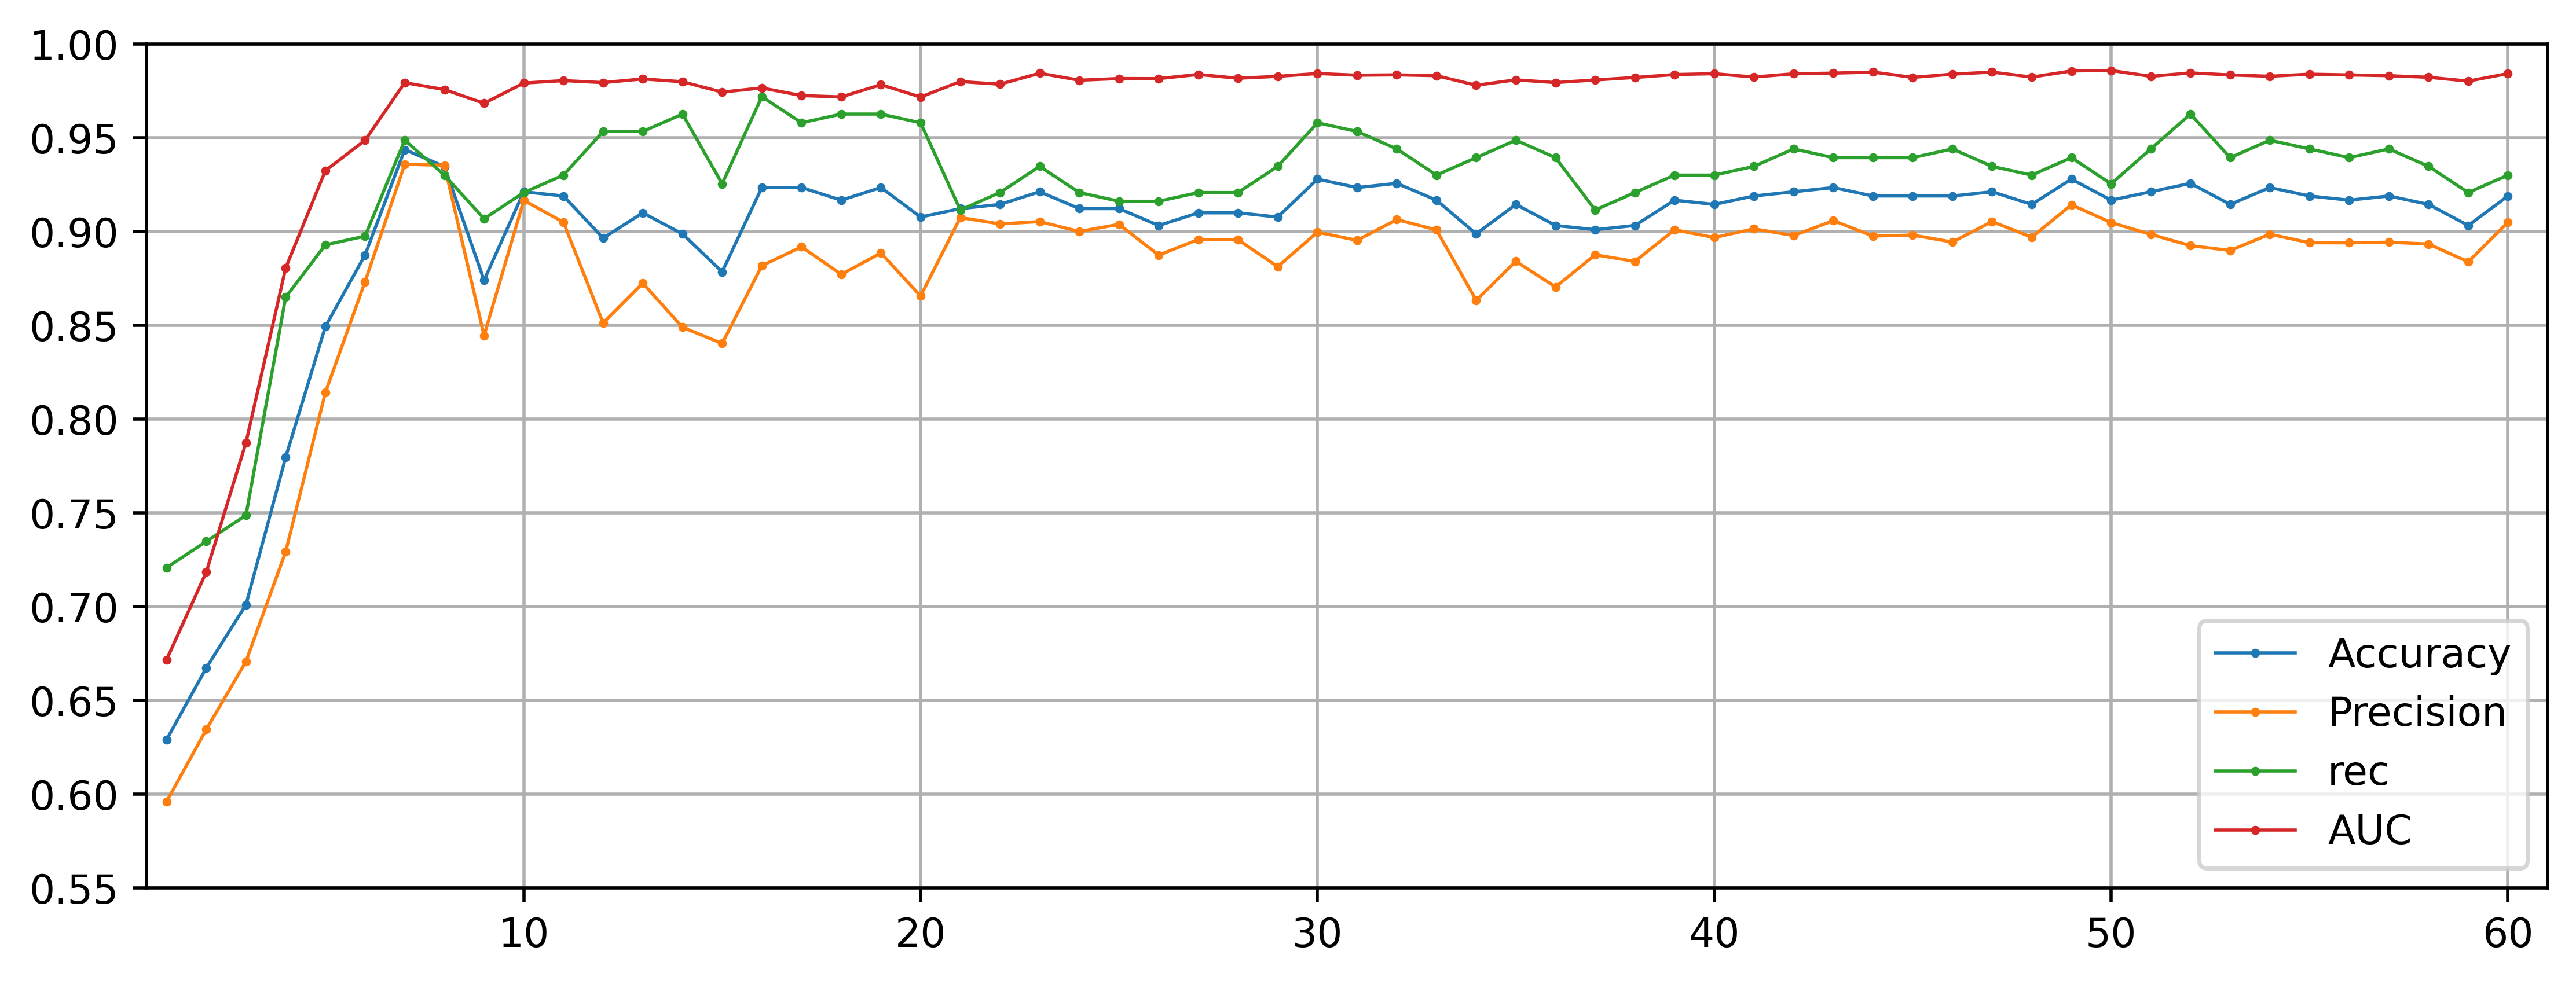

In [18]:
pointnum = bar
x_axi = geneNum[:pointnum]
plt.figure(figsize=(9, 3.5), dpi=500)
plt.xlim(0.5, 61)
plt.ylim(0.55, 1)

markersize = 2.5
linewidth = 0.8

plt.plot(x_axi, acc[:pointnum], '.-',label='Accuracy', markersize= markersize, linewidth = linewidth)
plt.plot(x_axi, prec[:pointnum], '.-',label='Precision', markersize= markersize, linewidth = linewidth)
plt.plot(x_axi, rec[:pointnum], '.-',label='rec', markersize= markersize, linewidth = linewidth)
plt.plot(x_axi, auc[:pointnum], '.-',label='AUC', markersize= markersize, linewidth = linewidth)

plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

# Run the feature elimination algorithm.

In [24]:
reserved_gene_idx = []
alternative_gene_idx = [i for i in range(order_gene.shape[0])]

init_acc = 0

geneNum = []
acc = []
prec = []
rec = []
auc = []

times = order_gene.shape[0]

# train-test split    random_state=2022
X_train, X_test, y_train, y_test = train_test_split(feature_after_GENIE3, label, test_size=0.3, shuffle=True, random_state=2022)

for i in range(times):
    
    geneNum.append(i + 1)
    reserved_gene_idx += [alternative_gene_idx[i]]
    
    xTrain = X_train[:, np.array(reserved_gene_idx)]
    xTest = X_test[:, np.array(reserved_gene_idx)]

    allAcc = []
    allPrec = []
    allRec = []
    allAuc = []
    
    for _ in range(5):
        rf = RandomForestClassifier()
        rf.fit(xTrain, y_train)  
        y_pred = rf.predict(xTest)
        
        allAcc.append(accuracy_score(y_test, y_pred))
        allPrec.append(precision_score(y_test, y_pred))
        allRec.append(recall_score(y_test, y_pred))
        predict_prob_y = rf.predict_proba(xTest)[:, 1]
        allAuc.append(roc_auc_score(y_test, predict_prob_y))

    if np.array(allAcc).mean() > init_acc:
        init_acc = np.array(allAcc).mean()
        
        acc.append(np.array(allAcc).mean())
        prec.append(np.array(allPrec).mean())
        rec.append(np.array(allRec).mean())
        auc.append(np.array(allAuc).mean())
    else:
        reserved_gene_idx.remove(alternative_gene_idx[i])
        
        
geneNum = np.array(geneNum)
acc = np.array(acc)
prec = np.array(prec)
rec = np.array(rec)
auc = np.array(auc)

feature_elimination_path = "result_data/feature_elimination_genie3_asc_"

np.save(feature_elimination_path + "acc.npy", acc)
np.save(feature_elimination_path + "prec.npy", prec)
np.save(feature_elimination_path + "rec.npy", rec)
np.save(feature_elimination_path + "auc.npy", auc)

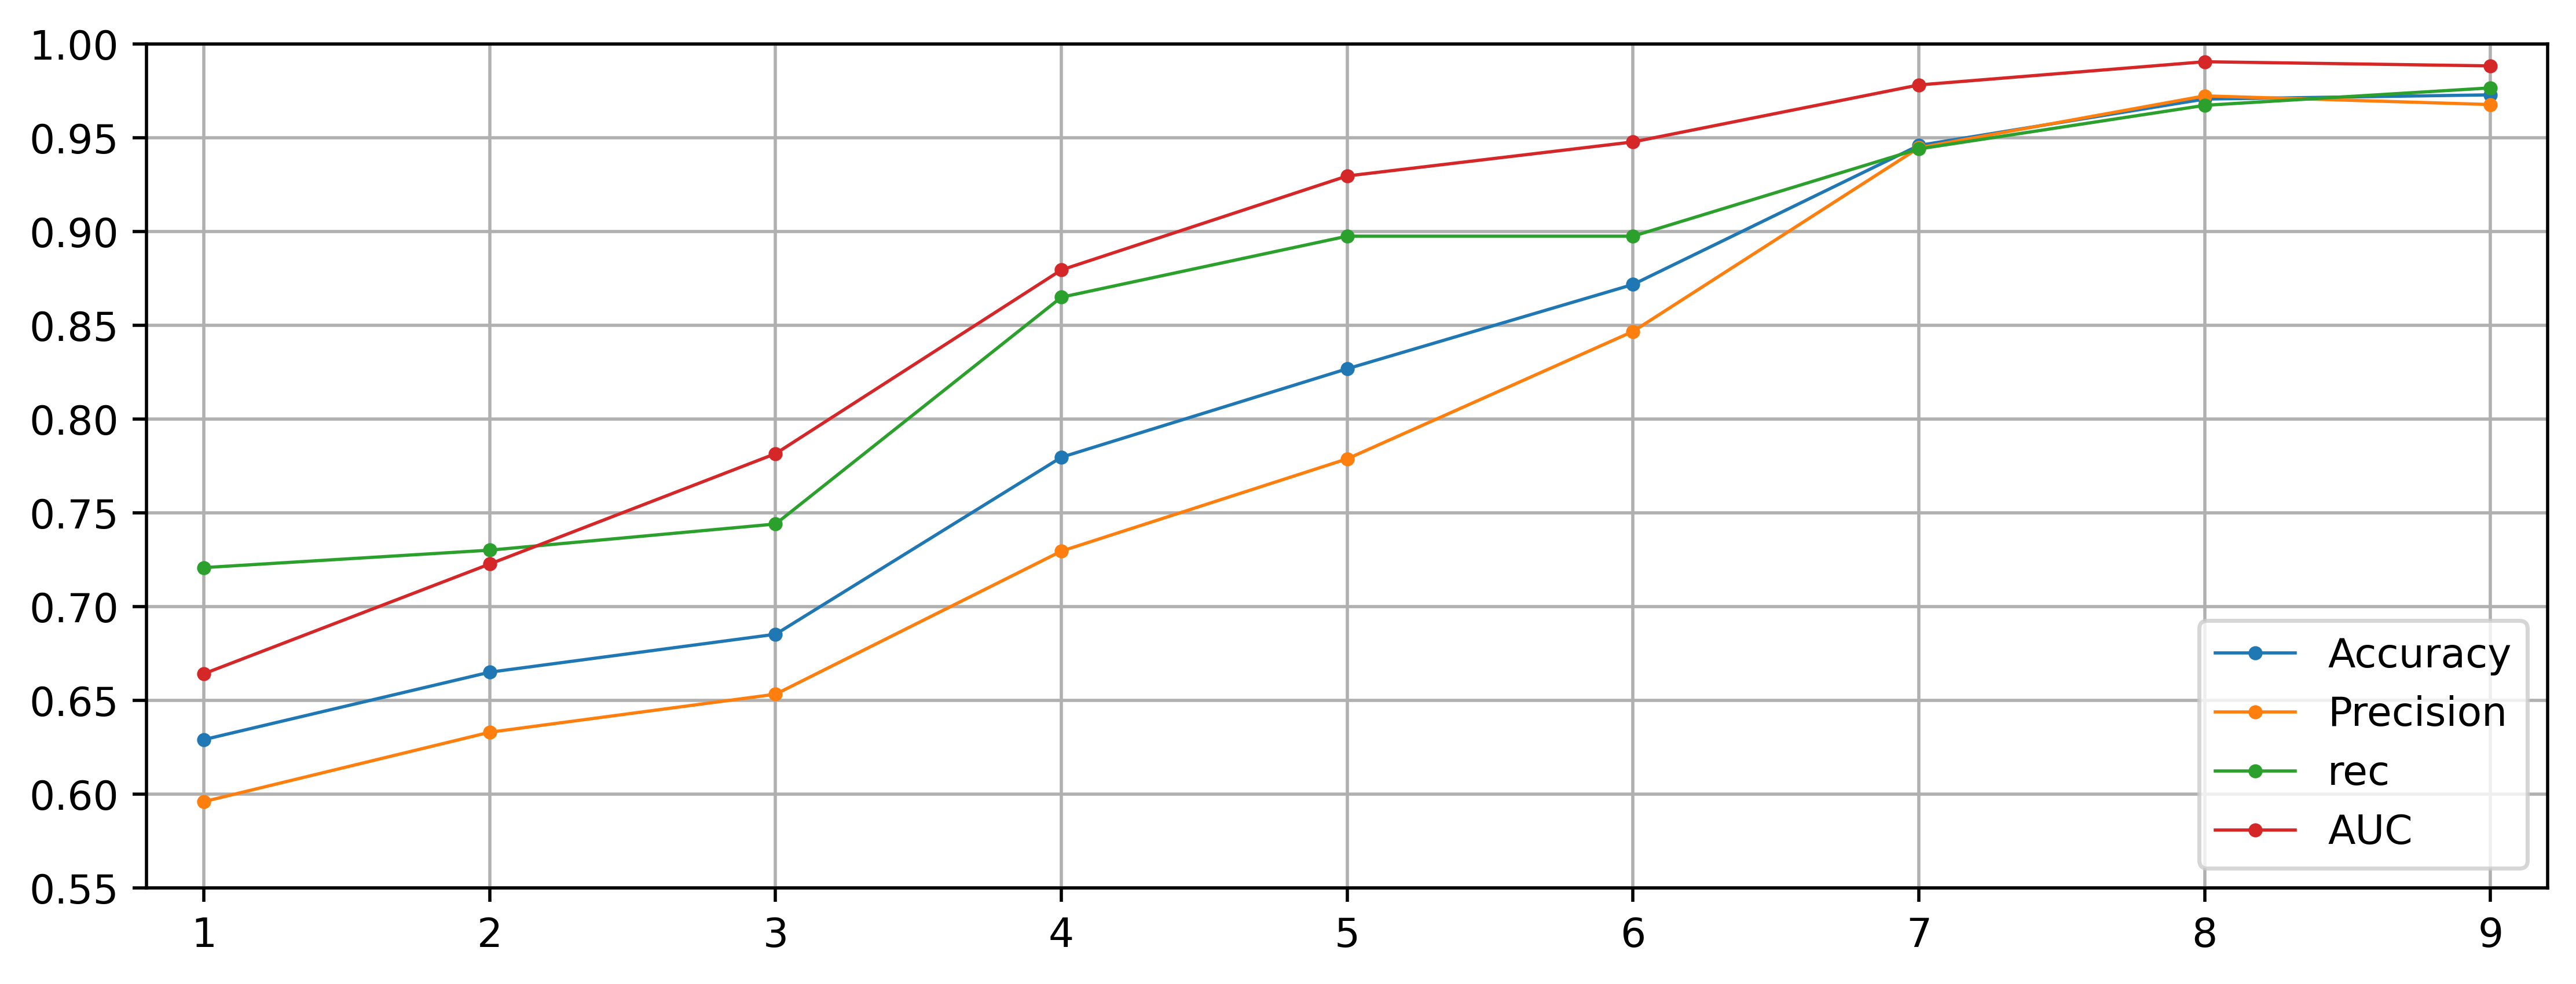

In [27]:
ISGnum = bar = len(acc)

pointnum = bar
x_axi = geneNum[:pointnum]
plt.figure(figsize=(9, 3.5), dpi=500)
plt.xlim(0.8, 9.2)
plt.ylim(0.55, 1)

markersize = 5
linewidth = 0.8

plt.plot(x_axi, acc[:pointnum], '.-',label='Accuracy', markersize= markersize, linewidth = linewidth)
plt.plot(x_axi, prec[:pointnum], '.-',label='Precision', markersize= markersize, linewidth = linewidth)
plt.plot(x_axi, rec[:pointnum], '.-',label='rec', markersize= markersize, linewidth = linewidth)
plt.plot(x_axi, auc[:pointnum], '.-',label='AUC', markersize= markersize, linewidth = linewidth)

plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

#### SPAG1, FIGN, NUBPL, CHMP5, TCF7L2, COQ10B, BSDC1, ZFPM1, GRPEL1,